# 1. Data Import and Cleaning 

In [152]:
import pandas as pd
df = pd.read_csv('sephora_website_dataset.csv') 
df.shape

(9168, 21)

In [154]:
# Perfume Dataset
perfume_dataset = df[df['category'].isin(['Perfume', 'Fragrance', 'Cologne'])]

# List of columns to drop
columns_to_drop = [
    'URL', 'MarketingFlags', 'MarketingFlags_content', 
    'options', 'online_only', 'exclusive', 
    'limited_edition', 'limited_time_offer'
]

# Drop the specified columns
perfume_dataset = perfume_dataset.drop(columns=columns_to_drop)


In [156]:
## Removing unknown in the dataset
perfume_dataset = perfume_dataset[perfume_dataset['ingredients'] != 'unknown']
perfume_dataset.reset_index(drop=True, inplace=True)
perfume_dataset = perfume_dataset.drop(columns='how_to_use')

In [158]:
## Extracting Fragrance Family using regex
perfume_dataset['fragrance_family'] = perfume_dataset['details'].str.extract(r'Fragrance Family:\s*([^\n]+?)\s*Scent Type', expand=False)
perfume_dataset = perfume_dataset.dropna(subset=['fragrance_family'])
# Define a dictionary to map variations to standardized names
fragrance_family_mapping = {
    'Florals': 'Floral',
    'Warm and Spicy': 'Warm & Spicy',
    'Warm  & Spicy': 'Warm & Spicy',
    'Warm & Sweet Gourmands': 'Warm & Spicy',
    'Earth & Woody': 'Earthy & Woody',
    'Eathy & Woody': 'Earthy & Woody',
    'Earthy and Woody': 'Earthy & Woody',
    'Woody & Earthy': 'Earthy & Woody'  
}
perfume_dataset['fragrance_family'] = perfume_dataset['fragrance_family'].replace(fragrance_family_mapping)

In [160]:
# Create the 'clean_at_sephora' column for Products with this label are formulated without certain ingredients, including: parabens, sulfates, phthalates, mineral oil, and formaldehyde
perfume_dataset['clean_at_sephora'] = perfume_dataset['ingredients'].apply(
    lambda x: 1 if 'Clean at Sephora' in str(x) else 0)


In [162]:
# Creating new column price per ml and using regex to extract 
perfume_dataset.loc[:, 'ml'] = perfume_dataset['size'].str.extract(r'(\d+)\s*mL', expand=False).astype(float)
perfume_dataset = perfume_dataset.dropna(subset=['ml'])
perfume_dataset.reset_index(drop=True, inplace=True)
perfume_dataset['price_per_ml'] = perfume_dataset['price'] / perfume_dataset['ml']


In [164]:
# Getting rid of travel size for consistent ml content
ml_counts = perfume_dataset.groupby('ml').size().reset_index(name='Count')
perfume_dataset = perfume_dataset[perfume_dataset['ml'] > 27]
perfume_dataset.shape

(336, 16)

# 2. Data- Preprocessing for Text Data Column (Ingredients)

In [166]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

def keep_chemical_names(text):
    # Convert to lowercase and remove punctuation
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    
    # Define a pattern to match common chemical name suffixes and structures
    chemical_pattern = r'\b\w+(?:ate|ine|ol|ide|one|ic|yl|ium|ene|gen|ine|ite|ane|acid|oxide)\b'
    chemical_names = [word for word in tokens if re.search(chemical_pattern, word)]
    
    # List of unwanted terms to remove
    unwanted_terms = {'synthetic', 'alcohol', 'organic', 'appropriate', 'plastic', 'date'}
    
    # Filter out unwanted terms
    cleaned_text = ' '.join([word for word in chemical_names if word not in unwanted_terms])
    return cleaned_text

def full_cleaning(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numerical values
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove stop words
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    processed_text = ' '.join(tokens)
    
    cleaned_text = keep_chemical_names(processed_text)
    return cleaned_text

perfume_dataset['cleaned_ingredients'] = perfume_dataset['ingredients'].apply(full_cleaning)

# 3. Analysis  

## 3.1 Figure 1 : Percentage of Top Ingredients by Fragrance Family

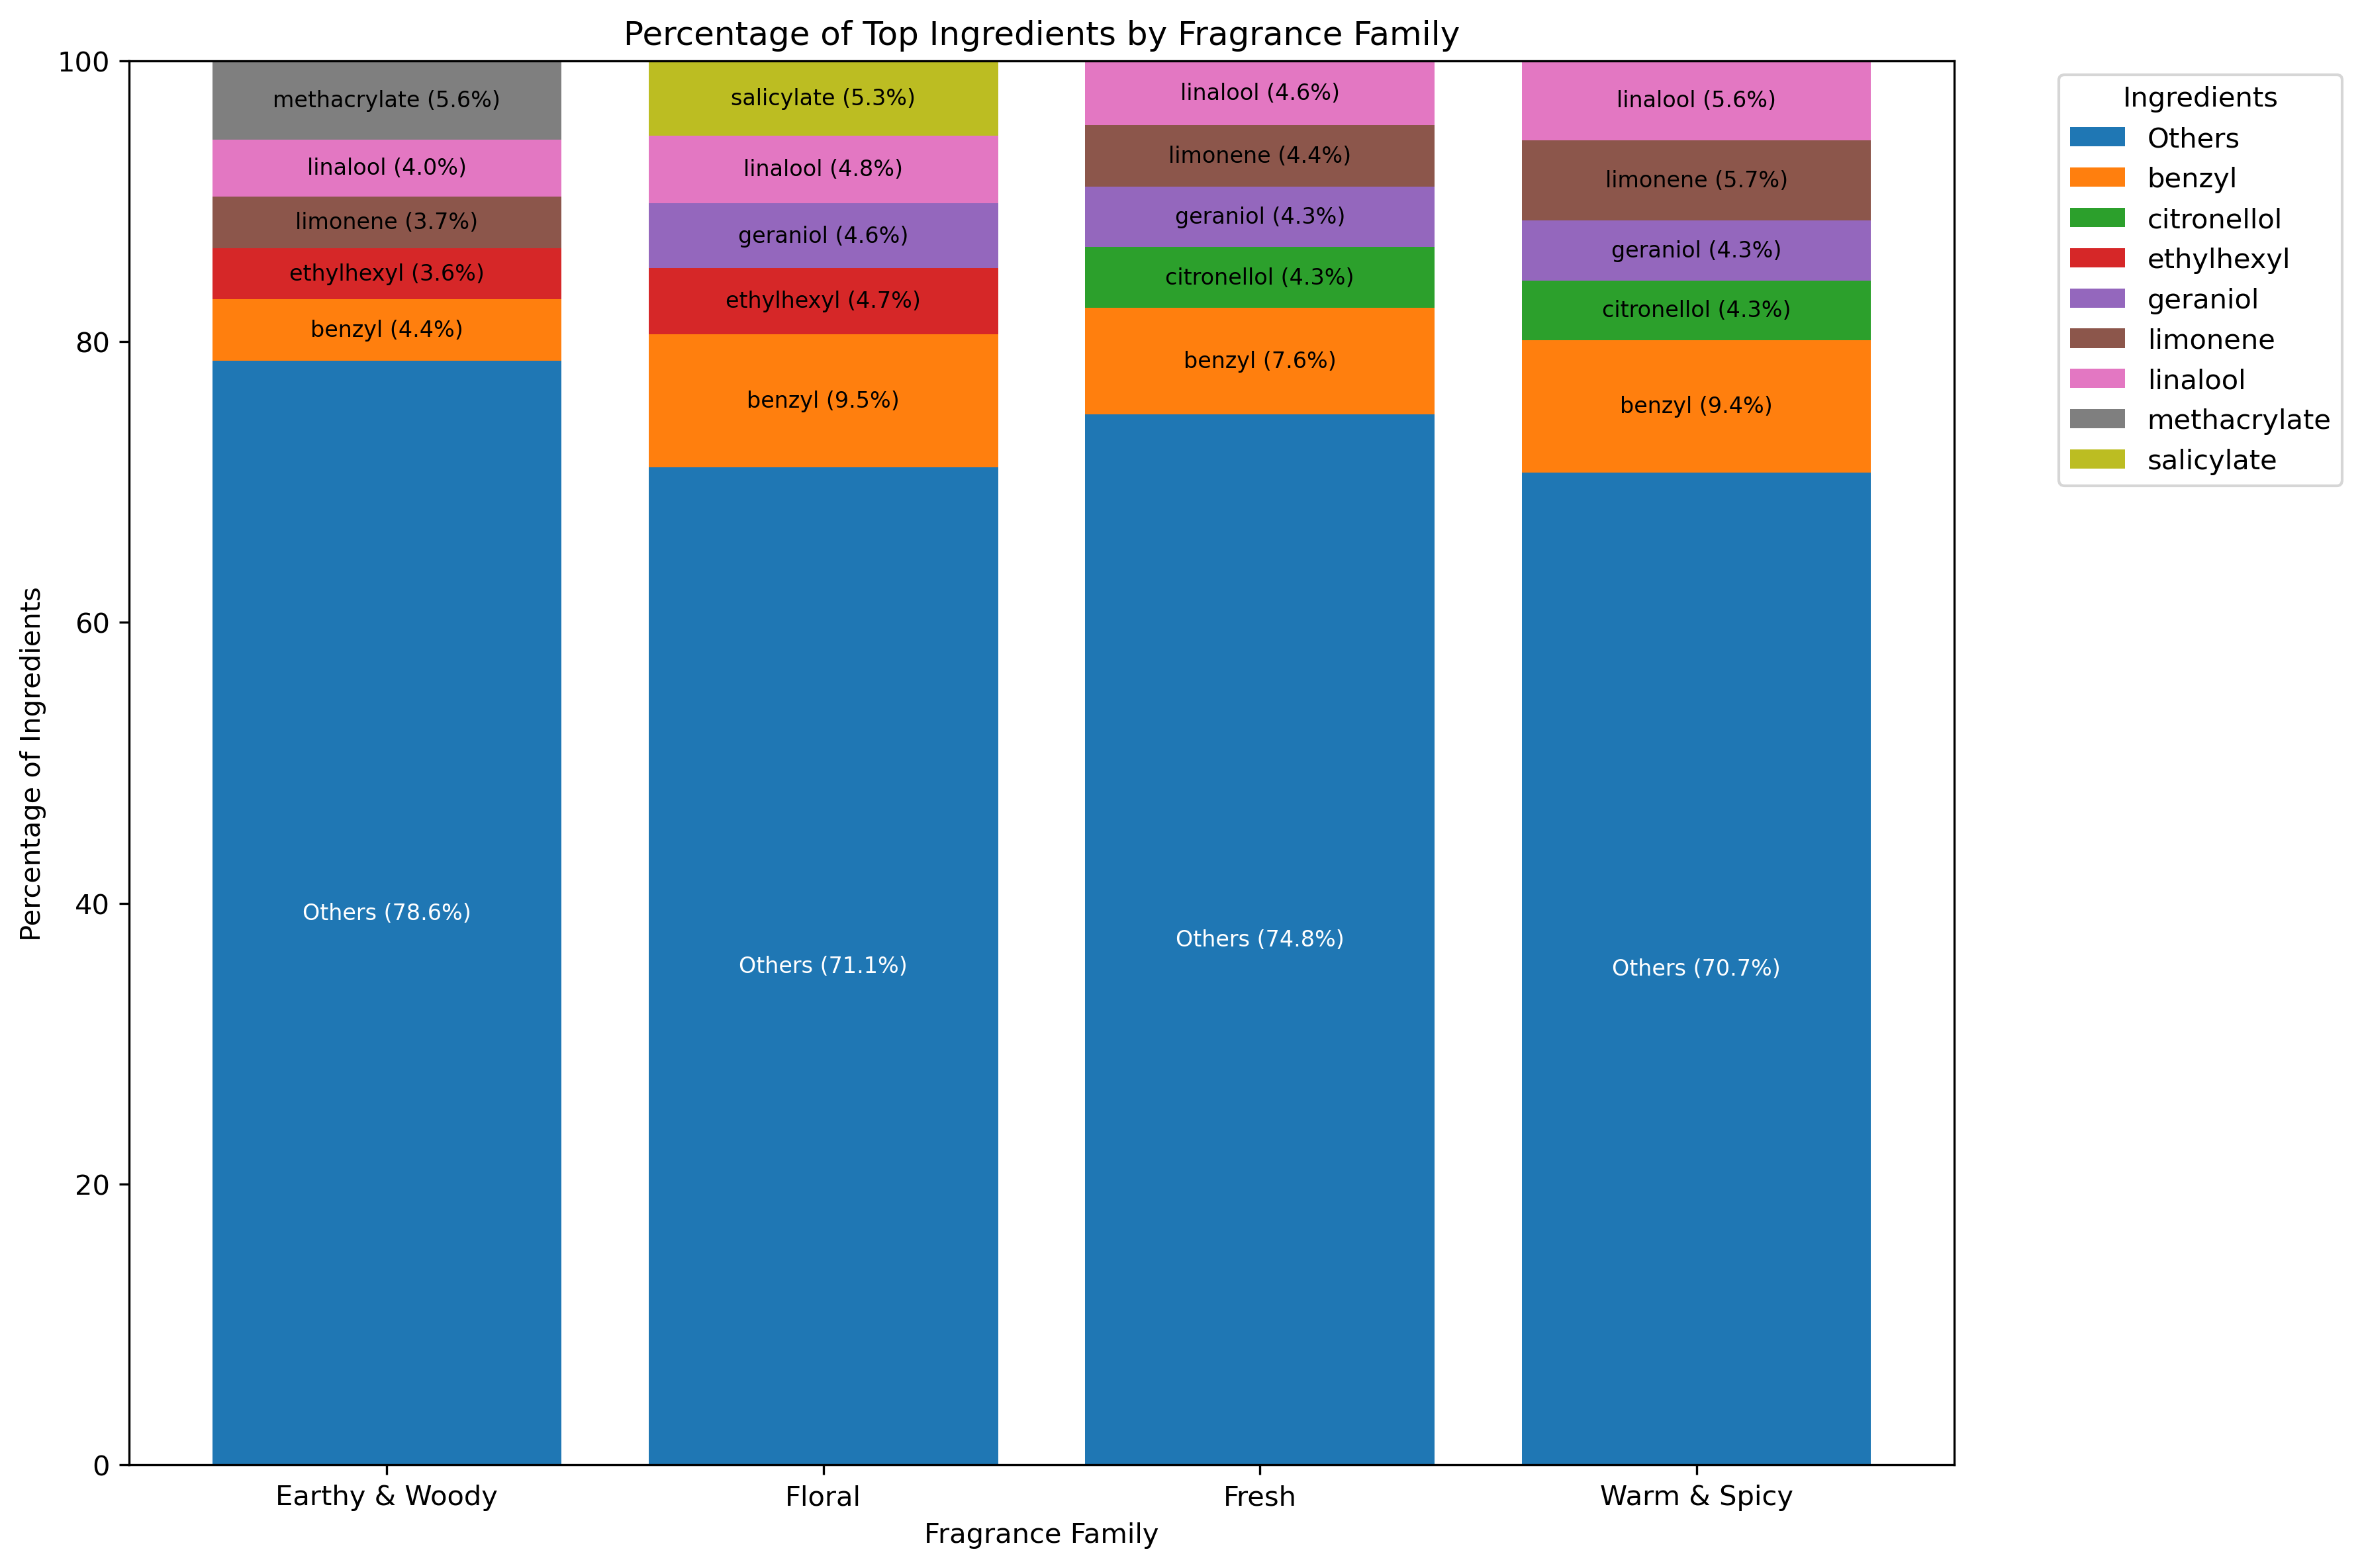

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

plt.rcParams['figure.dpi'] = 300
top_ingredients_df = pd.DataFrame()

# Calculate top 5 ingredients and "Others" for each Fragrance Family
for family, group in perfume_dataset.groupby('fragrance_family'):
    all_ingredients = ' '.join(group['cleaned_ingredients']).split()
    ingredient_counts = Counter(all_ingredients)
    top_5_ingredients = ingredient_counts.most_common(5)
    other_count = sum(count for ingredient, count in ingredient_counts.items() if ingredient not in dict(top_5_ingredients))
    
    # Create a DataFrame with the counts for this family
    family_df = pd.DataFrame(top_5_ingredients, columns=['Ingredient', family])
    family_df.set_index('Ingredient', inplace=True)
    family_df.loc['Others'] = other_count  # Add the "Others" segment
    
    # Join the results for each family into a single DataFrame
    top_ingredients_df = top_ingredients_df.join(family_df, how='outer')

# Fill NaN values with 0
top_ingredients_df = top_ingredients_df.fillna(0)

# Convert to percentages
top_ingredients_percentage = top_ingredients_df.div(top_ingredients_df.sum(axis=0), axis=1) * 100

# Plot the percentage-based stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Create the stacked bar chart with ingredients sorted
bottoms = pd.Series([0] * len(top_ingredients_percentage.columns), index=top_ingredients_percentage.columns)

for ingredient in top_ingredients_percentage.index:
    values = top_ingredients_percentage.loc[ingredient]
    bars = ax.bar(
        top_ingredients_percentage.columns,
        values,
        bottom=bottoms,
        label=ingredient
    )
    
    # Annotate each bar with ingredient name and percentage
    for bar, percentage in zip(bars, values):
        if percentage > 0:  
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{ingredient} ({percentage:.1f}%)",
                ha='center',
                va='center',
                fontsize=8,
                color='white' if percentage > 15 else 'black'  
            )   
    bottoms += values

# Formatting the plot
ax.set_title("Percentage of Top Ingredients by Fragrance Family")
ax.set_xlabel("Fragrance Family")
ax.set_ylabel("Percentage of Ingredients")
plt.xticks(rotation=0)
plt.legend(title="Ingredients", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 3.2 Figure 2 : Percentage of Clean Sephora Perfumes by Fragrance Family

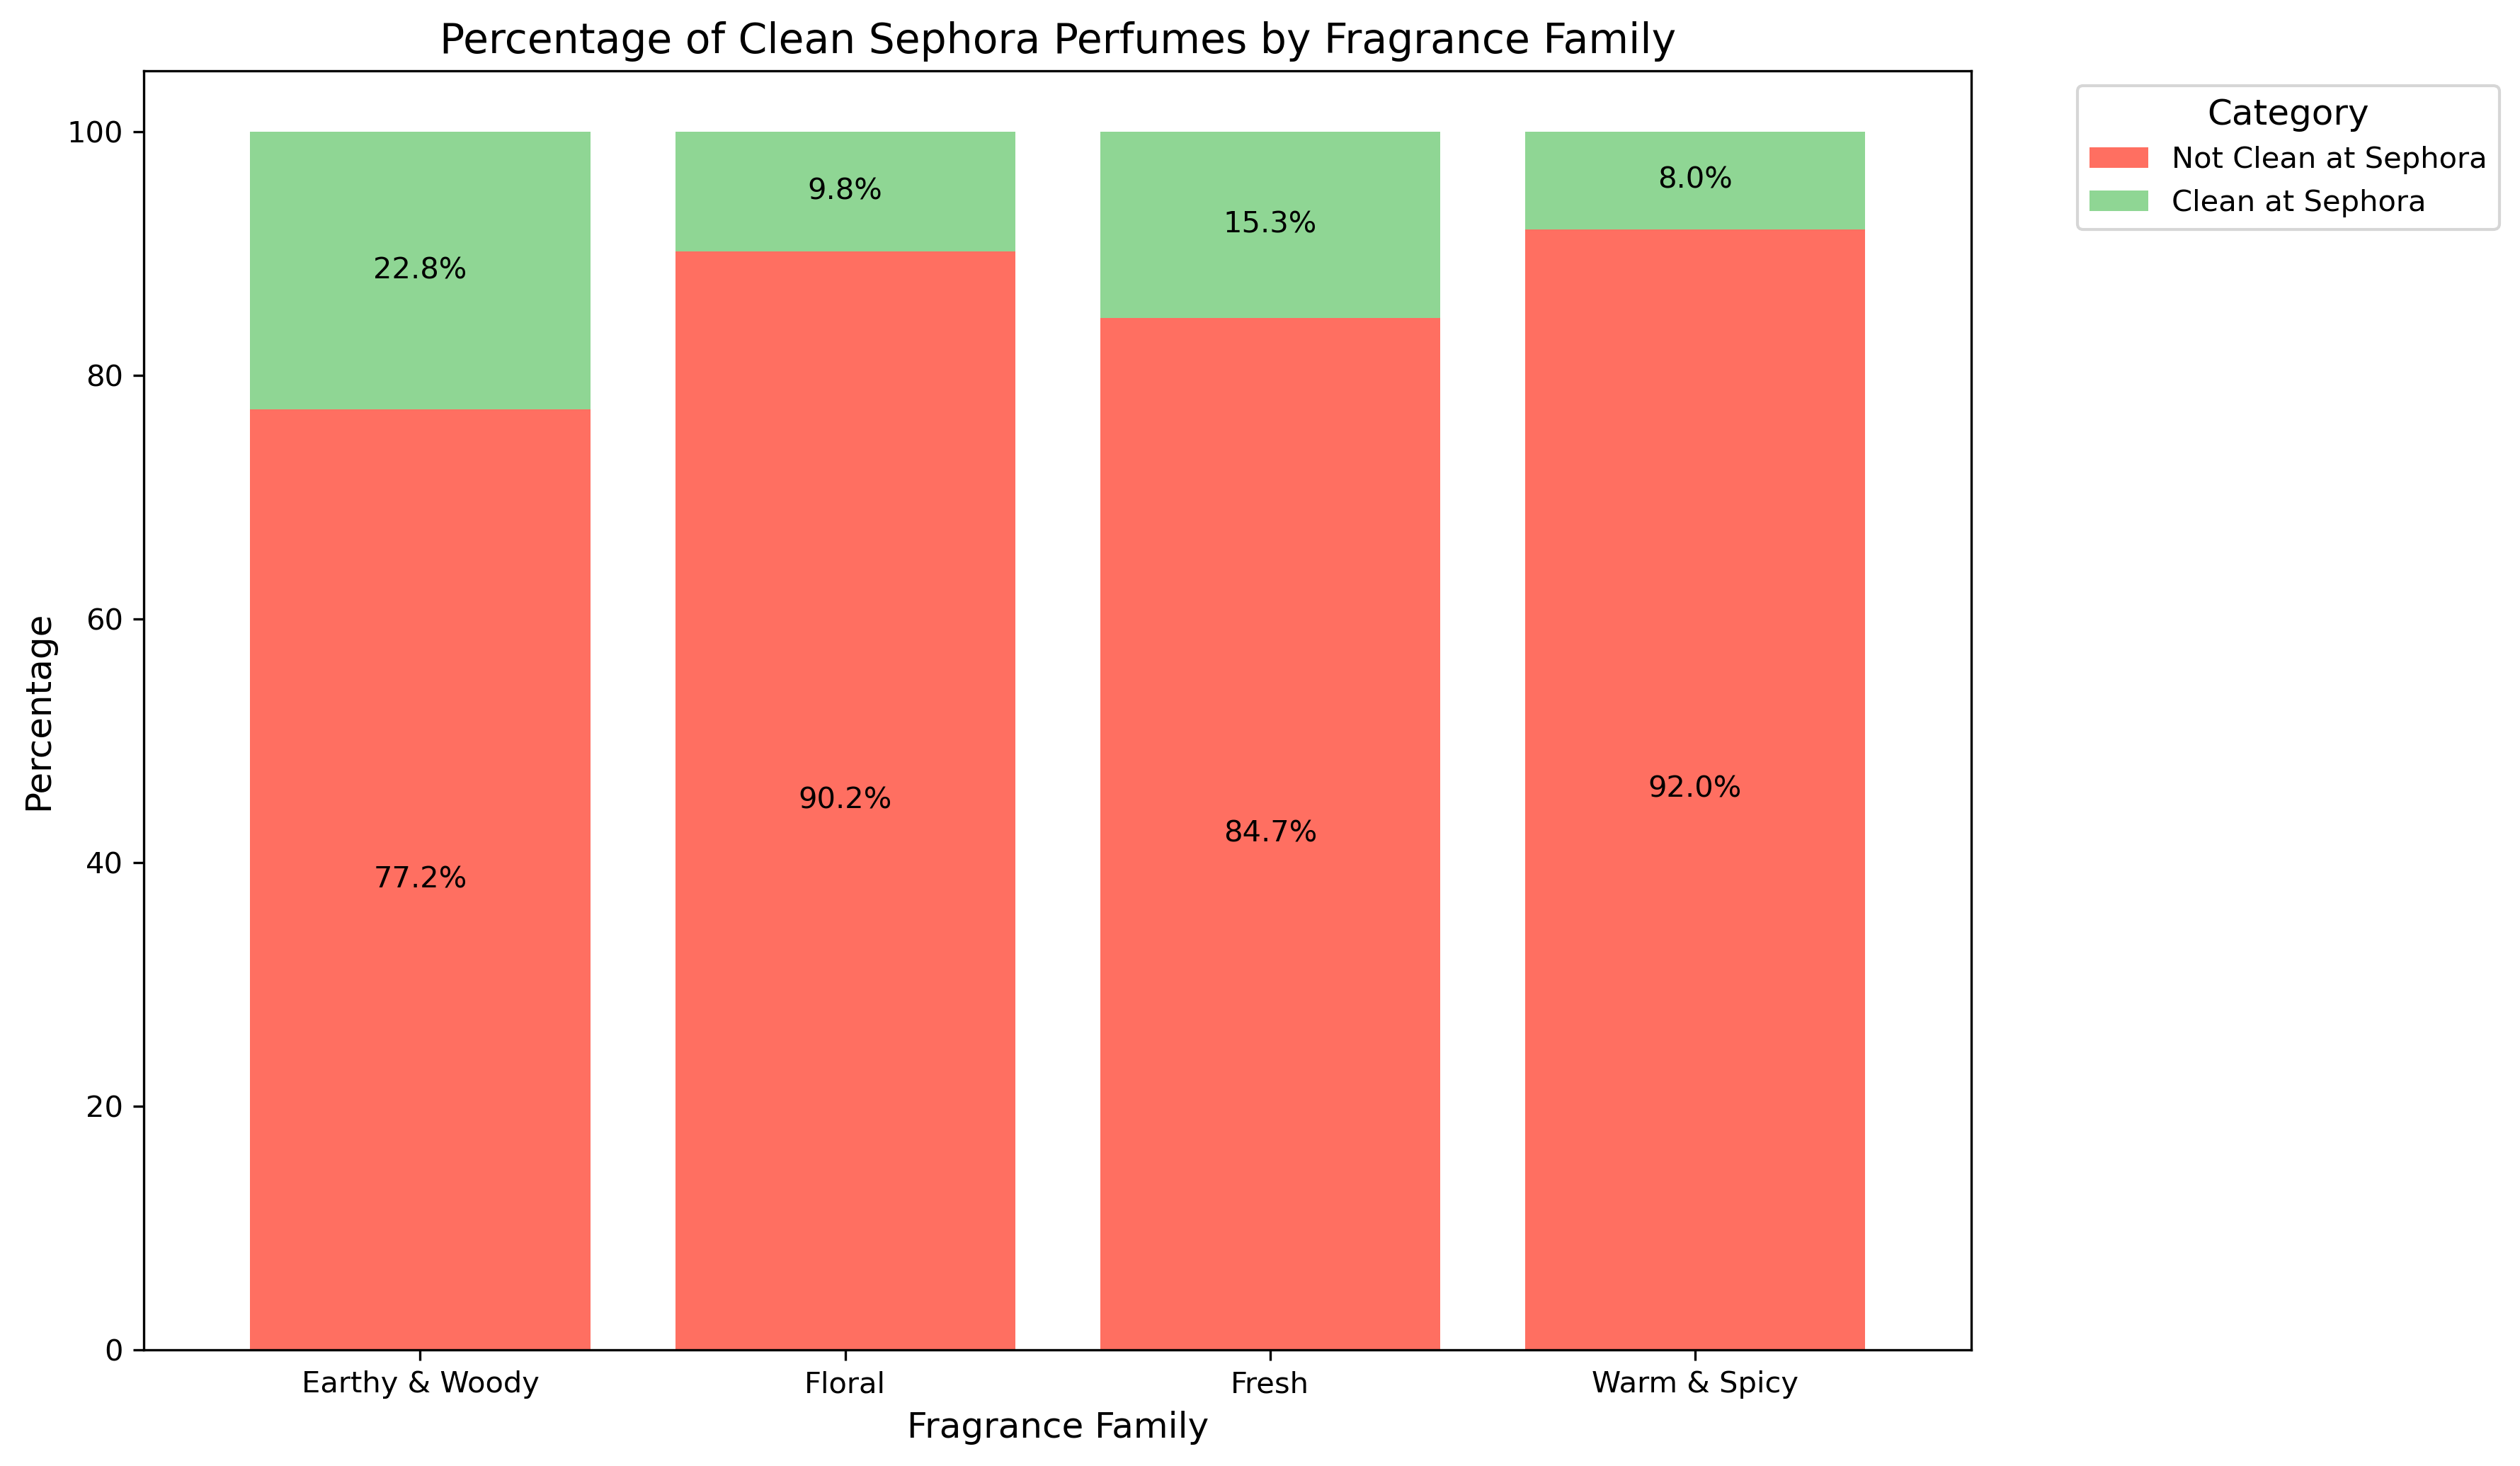

In [170]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.dpi'] = 300
clean_counts = perfume_dataset.groupby('fragrance_family')['clean_at_sephora'].sum()
total_counts = perfume_dataset.groupby('fragrance_family')['clean_at_sephora'].count()
percent_clean = (clean_counts / total_counts) * 100
percent_not_clean = 100 - percent_clean

# Create a DataFrame for plotting with "Not Clean at Sephora" first and "Clean at Sephora" second
data = pd.DataFrame({
    'Not Clean at Sephora': percent_not_clean,
    'Clean at Sephora': percent_clean
})

# Plot the stacked bar graph using pandas
ax = data.plot(
    kind='bar',
    stacked=True,
    color=['#FF6F61', '#8FD694'],  # Red for "Not Clean at Sephora" and Green for "Clean at Sephora"
    width=0.8, 
    figsize=(12, 7)
)

# Add labels to each bar segment
for i, (clean, not_clean) in enumerate(zip(percent_clean, percent_not_clean)):
    ax.text(i, not_clean / 2, f"{not_clean:.1f}%", ha='center', va='center', color='black', fontsize=10)
    ax.text(i, not_clean + (clean / 2), f"{clean:.1f}%", ha='center', va='center', color='black', fontsize=10)

# Formatting the plot
ax.set_title("Percentage of Clean Sephora Perfumes by Fragrance Family", fontsize=14)
ax.set_xlabel("Fragrance Family", fontsize=12)
ax.set_ylabel("Percentage", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.legend(title="Category", title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 3.2 Figure 3: Top 3 Brands in Fragrance Family by Love Count

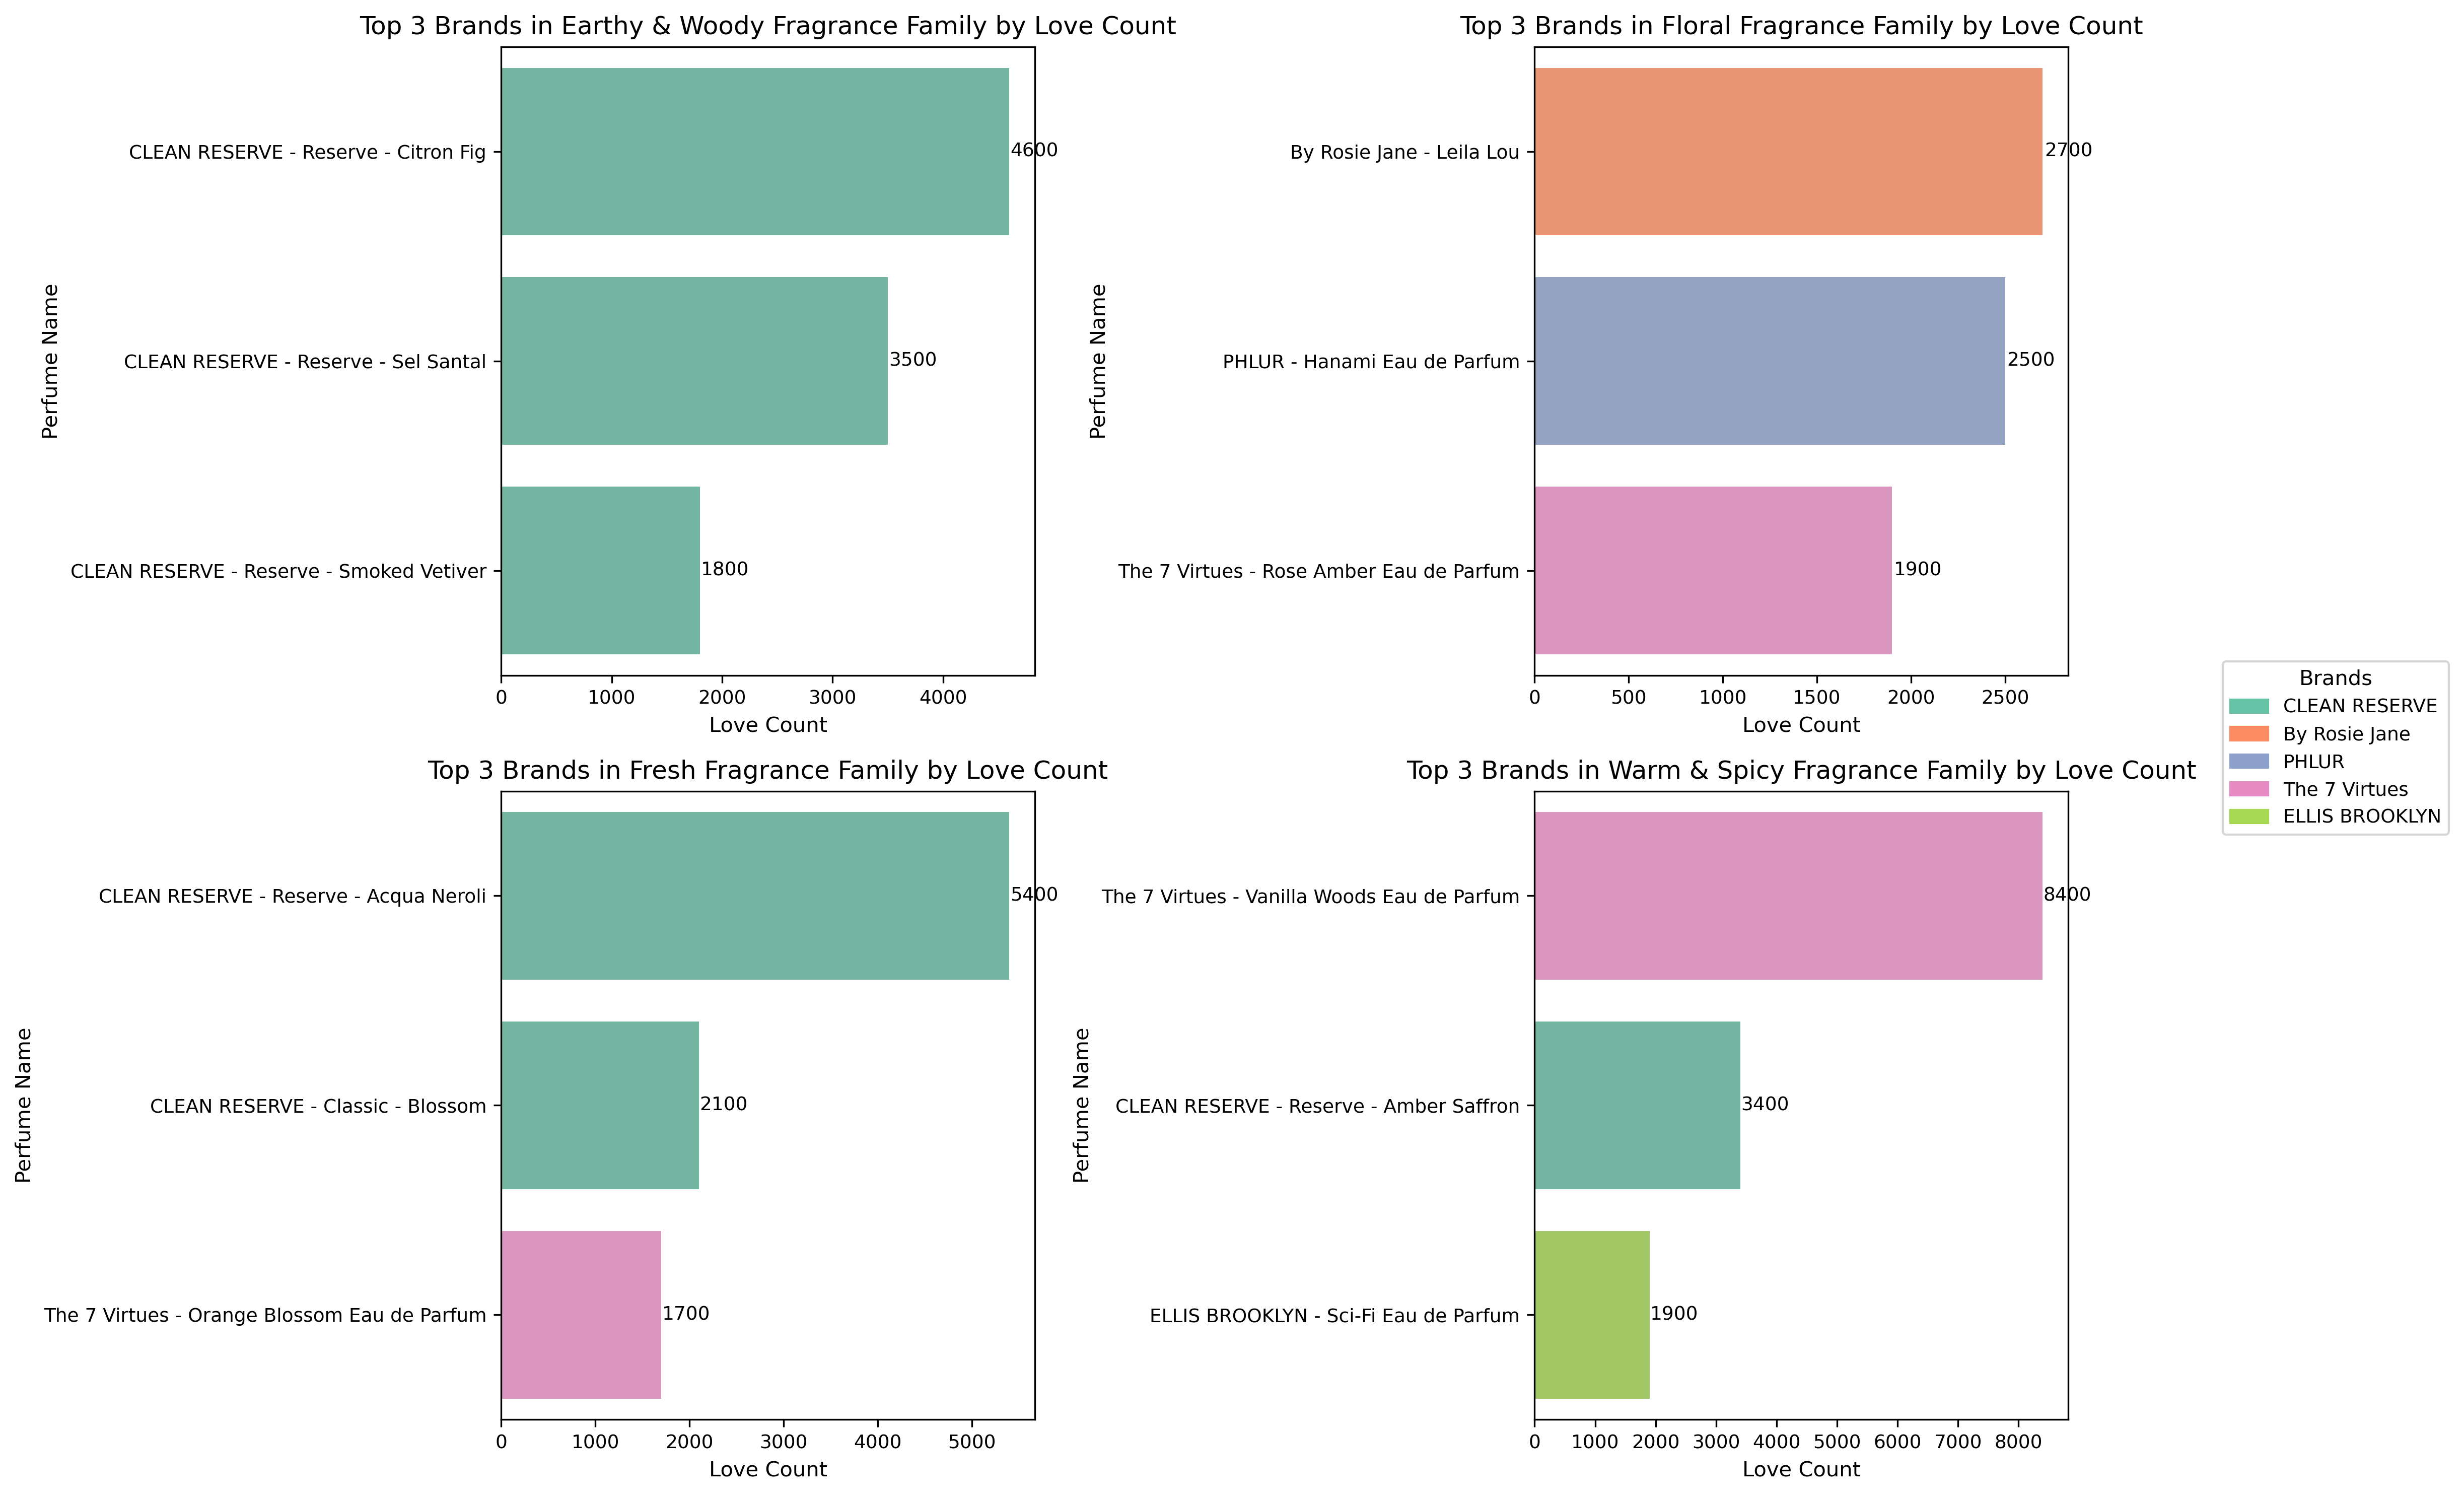

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

plt.rcParams['figure.dpi'] = 300

# Filter the dataset to include only "Clean at Sephora" products
clean_sephora_products = perfume_dataset[perfume_dataset['clean_at_sephora'] == 1]
top_brands_by_love = clean_sephora_products.groupby(['fragrance_family', 'brand', 'name'])['love'].sum().reset_index()

# Create a new column that combines brand and name
top_brands_by_love['brand_name'] = top_brands_by_love['brand'] + ' - ' + top_brands_by_love['name']
top_brands_by_love = top_brands_by_love.sort_values(['fragrance_family', 'love'], ascending=[True, False])
top_3_brands_per_family = top_brands_by_love.groupby('fragrance_family').head(3)

# Get unique fragrance families and brands
fragrance_families = top_3_brands_per_family['fragrance_family'].unique()
unique_brands = top_3_brands_per_family['brand'].unique()
palette = sns.color_palette("Set2", len(unique_brands))
brand_colors = {brand: color for brand, color in zip(unique_brands, palette)}

# Determine the number of rows and columns for the 2x2 grid
num_plots = len(fragrance_families)
rows = (num_plots // 2) + (num_plots % 2) 

fig, axes = plt.subplots(rows, 2, figsize=(14, rows * 5))
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, family in enumerate(fragrance_families):
    subset = top_3_brands_per_family[top_3_brands_per_family['fragrance_family'] == family]
    
    bar_plot = sns.barplot(
        data=subset,
        x='love',
        y='brand_name',
        hue='brand',  
        palette=brand_colors,  
        ax=axes[i] 
    )
    
    for p in bar_plot.patches:
        if p.get_width() > 0: 
            bar_plot.annotate(format(p.get_width(), '.0f'), 
                              (p.get_width() + 10, p.get_y() + p.get_height() / 2), 
                              ha='left', va='center', 
                              fontsize=9, color='black')

    axes[i].set_title(f"Top 3 Brands in {family} Fragrance Family by Love Count", fontsize=12)
    axes[i].set_xlabel("Love Count", fontsize=10)
    axes[i].set_ylabel("Perfume Name", fontsize=10)
    axes[i].tick_params(axis='x', labelsize=9)
    axes[i].tick_params(axis='y', labelsize=9)
    
    # Remove the legend from the individual plot
    axes[i].legend_.remove()

# Create a master legend for all brands outside the grid
handles = [mpatches.Patch(color=color, label=brand) for brand, color in brand_colors.items()]
fig.legend(handles=handles, title="Brands", bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=9)

plt.subplots_adjust(hspace=0.5, wspace=0.3)  
plt.tight_layout()
plt.show()
